In [1]:
# default_exp stft

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *

# STFT

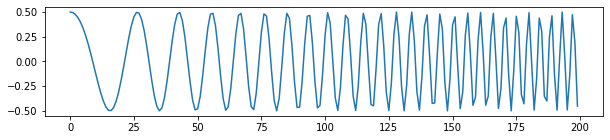

In [4]:
sr = 100
amp = 0.5

n_fft = 128

freq = [sr / n_fft * f for f in [3, 17]]

num_samples = 200
x = gen_sinusoid(amp, freq=freq, sample_rate=sr, num_samples=num_samples)

plot(x)

### COLA windows

Constant Overlap-Add

In [5]:
#export
def get_cola_window(window_name: str, n_window: int, n_hop: int):
    even_window = n_window % 2 == 0
    window_by_hop = n_window // n_hop

    if (window_name == 'hamming'):
        window = get_window(window_name, n_window, fftbins=even_window)
        if not even_window:
            window[ 0] /= 2
            window[-1] /= 2
        window /= (window_by_hop * 0.54)
        
    elif (window_name == 'hann' or window_name == 'hanning'):
        window = get_window(window_name, n_window, fftbins=even_window)
    
    elif (window_name == 'blackman'):
        window = get_window(window_name, n_window, fftbins=even_window)
        window /= (window_by_hop * 0.42)
        
    n_overlap = n_window - n_hop
    assert check_COLA(window, nperseg=n_window, noverlap=n_overlap)
    
    return window

In [6]:
get_cola_window('hamming', 33, 16) # ~1/2 overlap 
get_cola_window('hamming', 32, 16) #  1/2 overlap
get_cola_window('hamming', 33, 8)  # ~1/4 overlap
get_cola_window('hamming', 32, 8)  #  1/4 overlap
get_cola_window('hann', 33, 16) # ~1/2 overlap 
get_cola_window('hann', 32, 16) #  1/2 overlap
get_cola_window('hann', 33, 8)  # ~1/4 overlap
get_cola_window('hann', 32, 8);  #  1/4 overlap

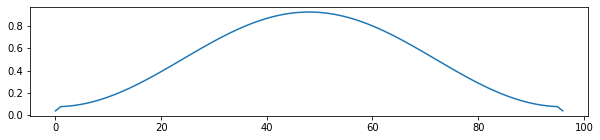

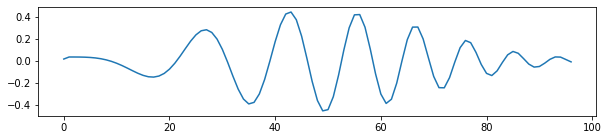

In [7]:
m = 97
h = 48
w = get_cola_window('hamming', m, h)
plot(w)
wx = x[:m] * w
plot(wx)

In [8]:
#export
def gen_frames(x, n_window, n_hop, window = None, pad_center=False):
    if pad_center:
        n_pad = n_window // 2
    else:
        n_overlap = n_window - n_hop
        n_pad = n_overlap
        
    x = np.pad(x, (n_pad, 0), mode='constant')
    i = 0
    
    if window is not None:
        window = window / window.sum()
    
    while i < x.size:
        frame = x[i:i+n_window]
        if frame.size < n_window:
            frame = np.pad(frame, (0, n_window-frame.size), mode='constant')
        if window is not None:
            frame = frame * window
        yield frame
        i += n_hop

In [9]:
frames = list(gen_frames(x, m, h, w))
# for frame in frames:
#     plot(frame)

In [10]:
#export
def synth_frames(frames, n_hop, n_samples: int = None, pad_center=False):
    frames = list(frames)
    n_frames = len(frames) # TODO: make synth_frames a generator ?
    n_window = frames[0].size
    
    buffer_len = n_window + n_hop*(n_frames-1)
    y = np.zeros(buffer_len, dtype=frames[0].dtype)
    
    for i, frame in enumerate(frames):
        offset_i = i*n_hop
        y[offset_i:offset_i+n_window] += frame * n_hop

    n_overlap = n_window - n_hop
    if pad_center:
        n_pad = n_window // 2
    else:
        n_pad = n_overlap
    
    y = y[n_pad:-n_pad]
    if n_samples is not None:
        y = y[:n_samples]
    return y

In [11]:
y = synth_frames(frames, h, x.size)
np.isclose(x, y).all()

True

In [12]:
#export
def stft(x, n_fft, n_hop, window, decibels=True, pad_center=False):
    n_window = window.size
    for x_i in gen_frames(x, n_window=n_window, n_hop=n_hop, window=window, pad_center=pad_center):
        m_x, p_x = fft_analysis(x_i, n_fft, decibels=decibels)
        yield m_x, p_x

In [13]:
#export 
def istft(spectrum, n_hop, n_window, n_samples: int = None, decibels: bool = True, pad_center=False):
    frames = (fft_synthesis(m_x, p_x, n_window, decibels=decibels) for m_x, p_x in spectrum)
    return synth_frames(frames, n_hop, n_samples, pad_center=pad_center)

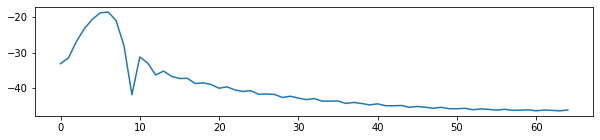

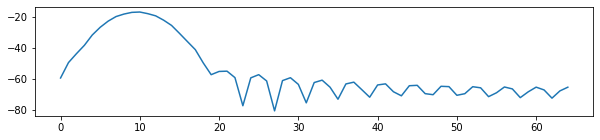

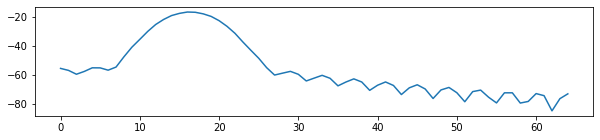

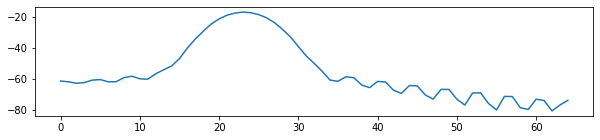

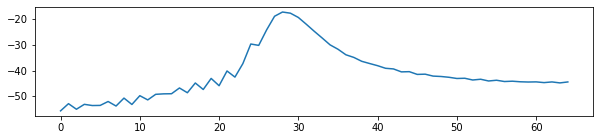

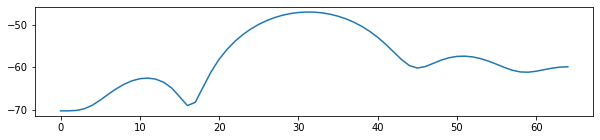

In [14]:
for m_x, p_x in stft(x, n_fft, h, w):
    plot(m_x)

In [15]:
spectrum = list(stft(x, n_fft, h, w))

In [16]:
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))

In [17]:
m_xs.shape, p_xs.shape

((6, 65), (6, 65))

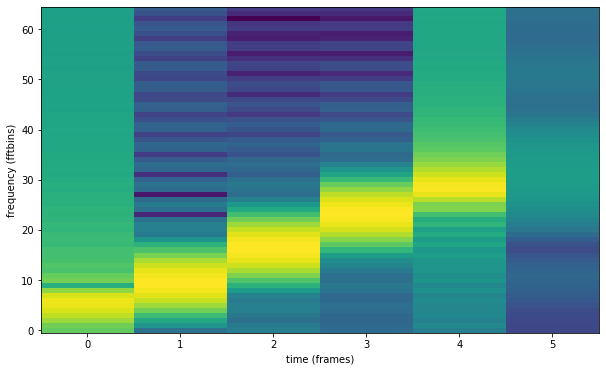

In [18]:
plot_mags(m_xs)

In [19]:
import librosa 

In [20]:
Yl = librosa.stft(x, n_fft=n_fft, hop_length=h, win_length=m, window='hamming', pad_mode='constant')
Yl.shape
abs(Yl).max(), m_xs.max()

(7.5245814, -16.77523383485155)

In [21]:
y = istft(spectrum, h, m, x.size)
np.isclose(x, y).all()

True

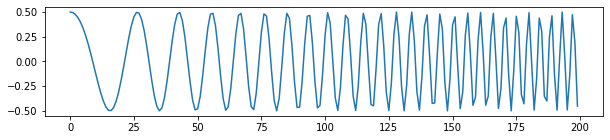

In [22]:
plot(y)

In [23]:
y = istft(stft(x, n_fft, h, w), h, m, x.size)
np.isclose(x, y).all()

True

### Real Example

In [24]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)

In [25]:
n_fft = 4096
h = 1024
m = h*2 + 1

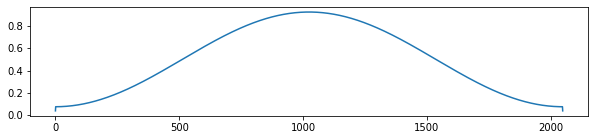

In [26]:
w = get_cola_window('hamming', m, h)
plot(w)
assert check_COLA(w, nperseg=m, noverlap=m-h)

In [27]:
spectrum = list(stft(x, n_fft, h, w))

In [28]:
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))

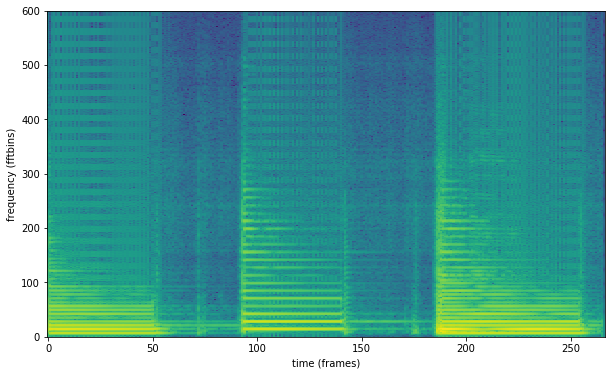

In [29]:
plot_mags(m_xs, max_bin=600)

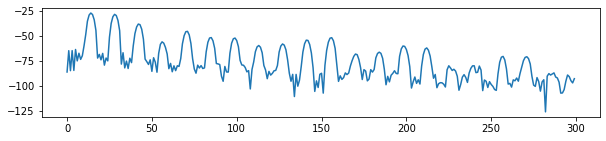

In [30]:
plot(m_xs[100,:300])

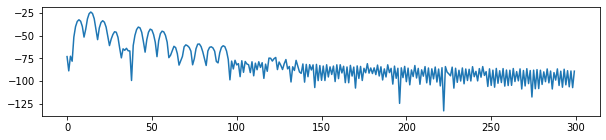

In [31]:
plot(m_xs[20,:300])

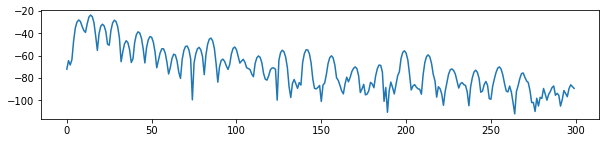

In [32]:
plot(m_xs[200,:300])

In [33]:
y = istft(spectrum, h, m, x.size)
np.isclose(x, y).all()

True

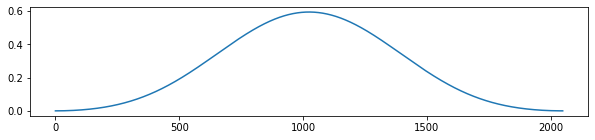

In [34]:
n_fft = 4096
h = 512
m = h*4 + 1
w = get_cola_window('blackman', m, h)
plot(w)

assert check_COLA(w, nperseg=m, noverlap=m-h)

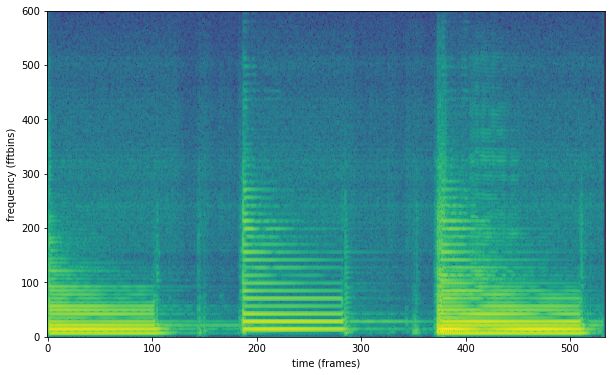

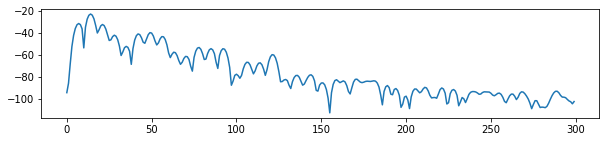

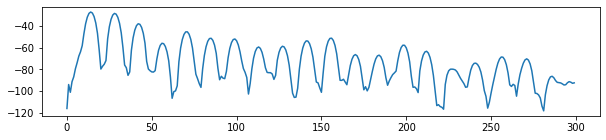

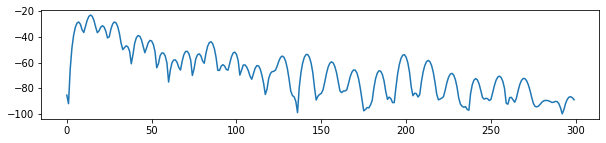

In [35]:
spectrum = list(stft(x, n_fft, h, w))
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))
plot_mags(m_xs, max_bin=600)
plot(m_xs[20,:300])
plot(m_xs[200,:300])
plot(m_xs[400,:300])

In [36]:
y = istft(stft(x, n_fft, h, w), h, m, x.size)
np.isclose(x, y).all()

True